# Title:   Forecast Bitcoin prices based on historical trends. 

## Columns:
  1. unix
  2. date
  3. symbol
  4. open
  5. high
  6. low
  7. close
  8. volume BTC
  9. volume USD

# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm # Auto-ARIMA for parameter tuning
import xgboost as xgb
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")  

ModuleNotFoundError: No module named 'tensorflow.python'

# Load the dataset

In [ ]:
# Load the dataset and parse the 'date' column as datetime
df = pd.read_csv("BTC-Daily.csv", parse_dates=['date'], index_col='date')

# Sort the data by date
df = df.sort_index()

print(df.head())

                  unix   symbol    open    high     low   close  Volume BTC  \
date                                                                          
2014-11-28  1417132800  BTC/USD  363.59  381.34  360.57  376.28  3220878.18   
2014-11-29  1417219200  BTC/USD  376.42  386.60  372.25  376.72  2746157.05   
2014-11-30  1417305600  BTC/USD  376.57  381.99  373.32  373.34  1145566.61   
2014-12-01  1417392000  BTC/USD  376.40  382.31  373.03  378.39  2520662.37   
2014-12-02  1417478400  BTC/USD  378.39  382.86  375.23  379.25  2593576.46   

            Volume USD  
date                    
2014-11-28     8617.15  
2014-11-29     7245.19  
2014-11-30     3046.33  
2014-12-01     6660.56  
2014-12-02     6832.53  


In [ ]:
df = df[['close']]  # Closing price is often used for trend analysis

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2651 entries, 2014-11-28 to 2022-03-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   2651 non-null   float64
dtypes: float64(1)
memory usage: 41.4 KB


In [ ]:
print(df.columns) 

Index(['close'], dtype='object')


# Finding missing values

In [ ]:
print(df.isnull().sum())  # Check for missing values
df.fillna(method='ffill', inplace=True)  # Forward fill missing values

close    0
dtype: int64


# EDA

# Visualizing Bitcoin Prices
- Plot the historical closing prices to understand trends.

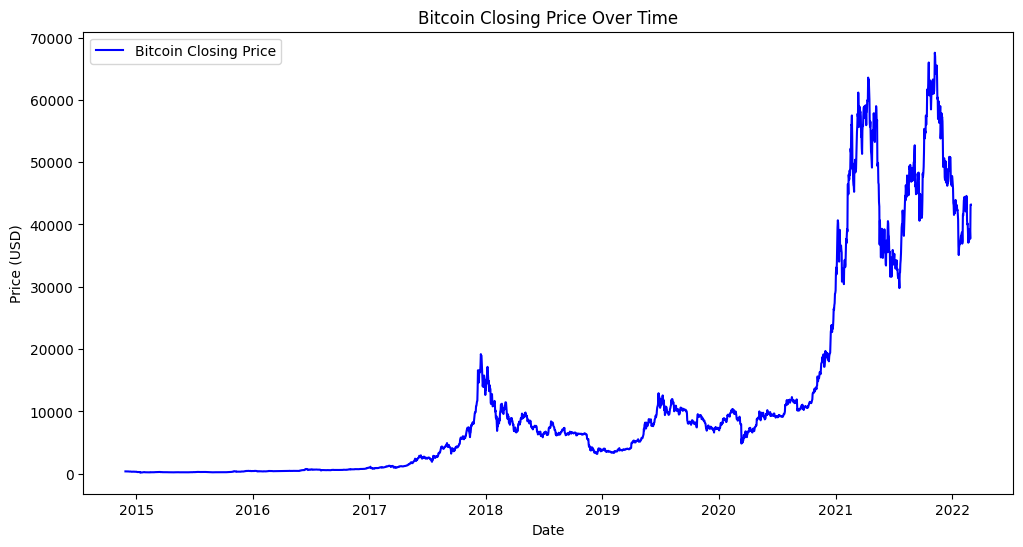

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df['close'], label='Bitcoin Closing Price', color='blue')
plt.title('Bitcoin Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# observation:
- This code creates a time series plot of Bitcoin's closing price, helping visualize trends and fluctuations over time. It sets the figure size, plots the closing price in blue, and labels the axes for clarity. The legend and title enhance readability, making it easier to analyze price movements

# Trend Analysis
- We analyze trends using Moving Averages and Seasonal Decomposition

##  Moving Averages (Trend Detection)

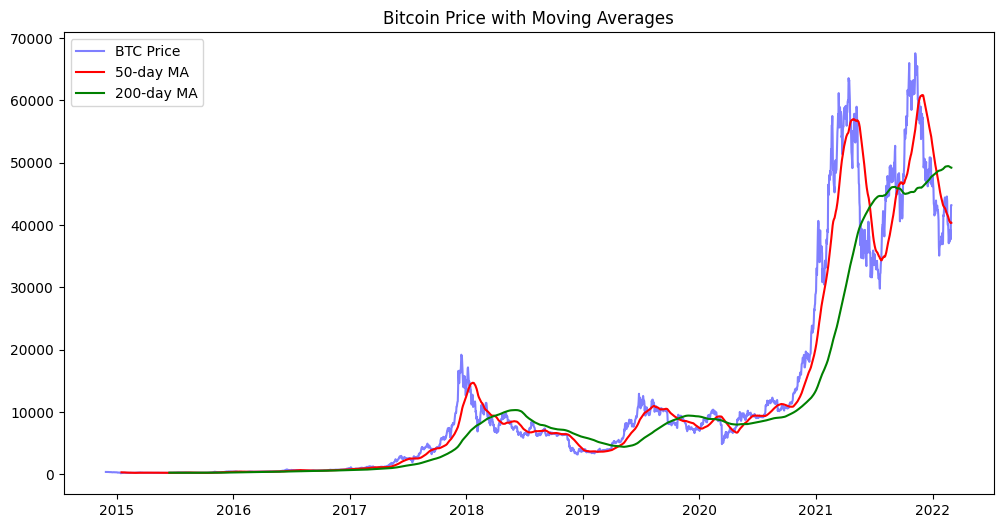

In [ ]:
df['SMA_50'] = df['close'].rolling(window=50).mean()  # 50-day moving average
df['SMA_200'] = df['close'].rolling(window=200).mean()  # 200-day moving average

plt.figure(figsize=(12,6))
plt.plot(df['close'], label="BTC Price", color='blue', alpha=0.5)
plt.plot(df['SMA_50'], label="50-day MA", color='red')
plt.plot(df['SMA_200'], label="200-day MA", color='green')
plt.title("Bitcoin Price with Moving Averages")
plt.legend()
plt.show()

##  Differencing (To Remove Trends & Check Stationarity)
- First-Order Differencing (∆1)

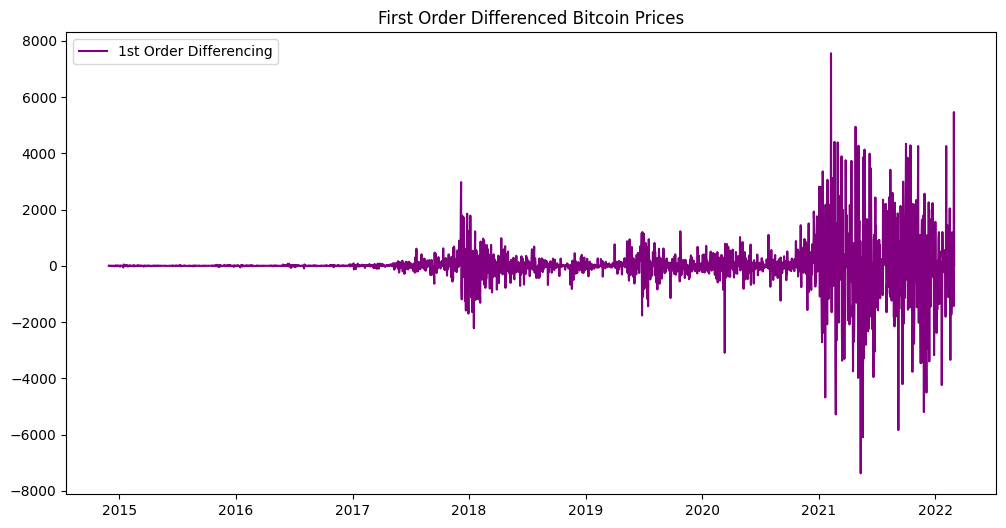

In [ ]:
df['diff_1'] = df['close'].diff()

plt.figure(figsize=(12,6))
plt.plot(df['diff_1'], color='purple', label="1st Order Differencing")
plt.title("First Order Differenced Bitcoin Prices")
plt.legend()
plt.show()

#  Checking for Stationarity (Augmented Dickey-Fuller (ADF) Test)

In [ ]:
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] < 0.05:
        print("The data is stationary.")
    else:
        print("The data is NOT stationary.")

# Run ADF Test on Bitcoin price data
adf_test(df['close'])

ADF Statistic: -0.9875841417510546
p-value: 0.7577657213555864
The data is NOT stationary.


## observation:
- If p-value < 0.05 → The data is stationary.

- If p-value > 0.05 → The data is non-stationary and needs transformation.

# Transforming Data for Stationarity

## Log Transformation

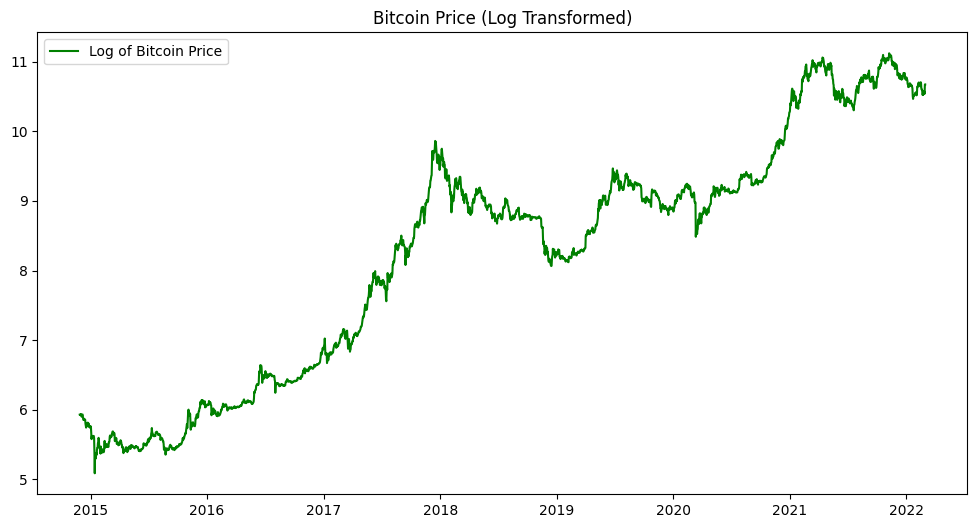

In [ ]:
df['Log_close'] = np.log(df['close'])

plt.figure(figsize=(12, 6))
plt.plot(df['Log_close'], label="Log of Bitcoin Price", color="green")
plt.title("Bitcoin Price (Log Transformed)")
plt.legend()
plt.show()

In [ ]:
adf_test(df['Log_close'])  # Check stationarity

ADF Statistic: -0.48117683076634776
p-value: 0.895637665434668
The data is NOT stationary.


# First-Order Differencing

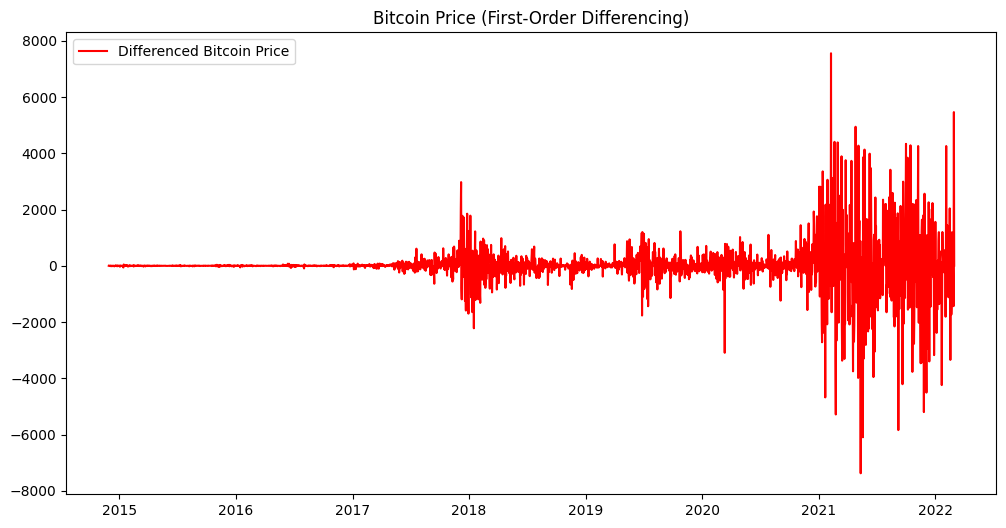

In [ ]:
df['close_Diff'] = df['close'].diff()

plt.figure(figsize=(12, 6))
plt.plot(df['close_Diff'], label="Differenced Bitcoin Price", color="red")
plt.title("Bitcoin Price (First-Order Differencing)")
plt.legend()
plt.show()

In [ ]:
df['Log_First_Diff'] = df['Log_close'].diff()  # Differencing log data

adf_test(df['Log_First_Diff'].dropna())  # Pass the differenced series

ADF Statistic: -54.2442284872577
p-value: 0.0
The data is stationary.


In [ ]:
# Check stationarity again
adf_test(df['close_Diff'].dropna())

ADF Statistic: -8.47850283038207
p-value: 1.4139138299592807e-13
The data is stationary.


# Identifying Trends & Seasonality

<Figure size 1200x800 with 0 Axes>

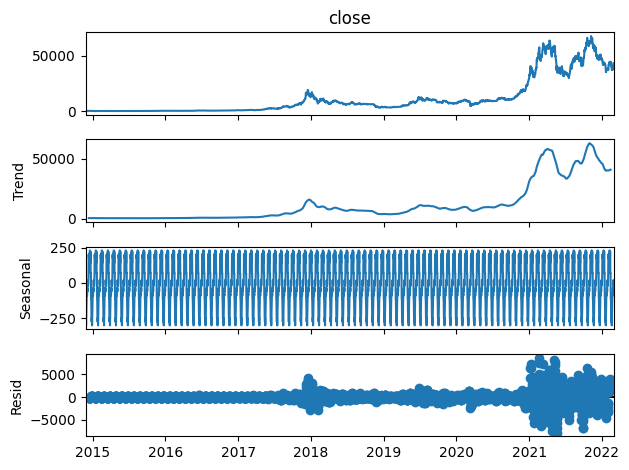

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose Bitcoin closing price
decomposition = seasonal_decompose(df['close'], model='additive', period=30)
plt.figure(figsize=(12, 8))
decomposition.plot()
plt.show()

##  Seasonal Decomposition (Trend, Seasonality, Residuals)

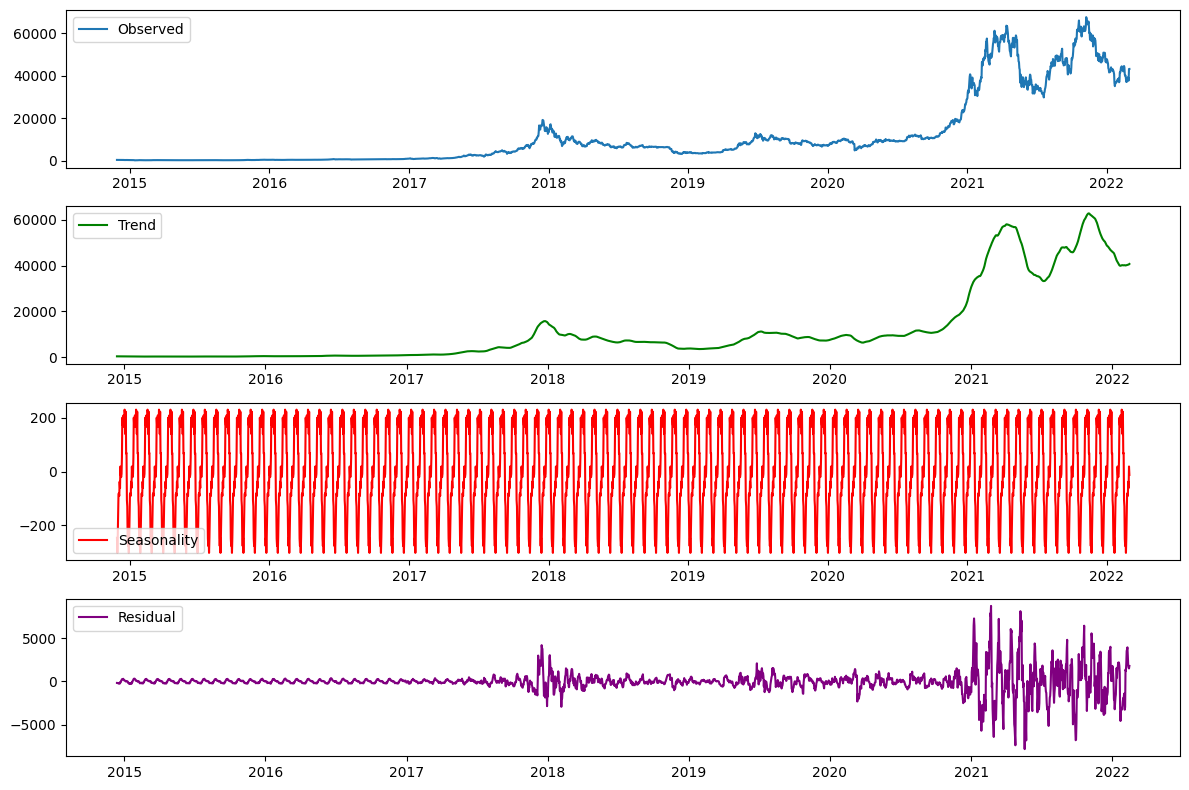

In [ ]:
decomposed = seasonal_decompose(df['close'], model='additive', period=30)

plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(decomposed.observed, label='Observed')
plt.legend()

plt.subplot(412)
plt.plot(decomposed.trend, label='Trend', color='green')
plt.legend()

plt.subplot(413)
plt.plot(decomposed.seasonal, label='Seasonality', color='red')
plt.legend()

plt.subplot(414)
plt.plot(decomposed.resid, label='Residual', color='purple')
plt.legend()

plt.tight_layout()
plt.show()

# Feature Engineering
- To improve forecasting accuracy, create new features based on historical data

## Rolling Averages
- Compute 7-day and 30-day moving averages to smooth trends.
## Lag Features
- Create lag features (previous day’s closing price) to capture dependencies

In [ ]:
# Rolling Averages
df['7_day_MA'] = df['close'].rolling(window=7).mean()
df['30_day_MA'] = df['close'].rolling(window=30).mean()

# Volatility Features
df['volatility_7'] = df['close'].rolling(window=7).std()
df['volatility_30'] = df['close'].rolling(window=30).std()

# Lag Features (Previous days' prices)
df['lag_1'] = df['close'].shift(1)        
df['lag_7'] = df['close'].shift(7)
df['lag_30'] = df['close'].shift(30)

# Drop NaN values
df.dropna(inplace=True)

# Train Test Split 
- (80% training, 20% testing)

In [ ]:
train_size = int(len(df) * 0.8)  # 80% training data
train, test = df.iloc[:train_size], df.iloc[train_size:]

## 1. ARIMA(AutoRegressive Integrated Moving Average)
- Best for trend-based forecasting.

In [ ]:
# Auto-tune ARIMA parameters
auto_arima_model = pm.auto_arima(train['close'], seasonal=False, stepwise=True, suppress_warnings=True)
print(f"Best ARIMA Order: {auto_arima_model.order}")

# Fit ARIMA model
arima_model = ARIMA(train['close'], order=auto_arima_model.order)
arima_fit = arima_model.fit()

# Forecast on test set
test['Forecast_ARIMA'] = arima_fit.predict(start=len(train), end=len(df)-1, dynamic=False)

# Evaluation Metrics
mae_arima = mean_absolute_error(test['close'], test['Forecast_ARIMA'])
rmse_arima = np.sqrt(mean_squared_error(test['close'], test['Forecast_ARIMA']))

print(f'ARIMA MAE: {mae_arima}')
print(f'ARIMA RMSE: {rmse_arima}')


Best ARIMA Order: (2, 1, 3)
ARIMA MAE: 29752.655485479838
ARIMA RMSE: 32437.29891838778


# >>Hyperparameter Tuning  for ARIMA<<

In [ ]:
from itertools import product
import statsmodels.api as sm

# Define the range of parameters
p = d = q = range(0, 5)
pdq = list(product(p, d, q))

best_aic = float("inf")
best_order = None
best_model = None

# Grid search over (p, d, q) combinations
for order in pdq:
    try:
        model = sm.tsa.arima.ARIMA(train['close'], order=order).fit()
        if model.aic < best_aic:
            best_aic = model.aic
            best_order = order
            best_model = model
    except:
        continue

print(f"Best ARIMA Order: {best_order}")

Best ARIMA Order: (1, 4, 3)


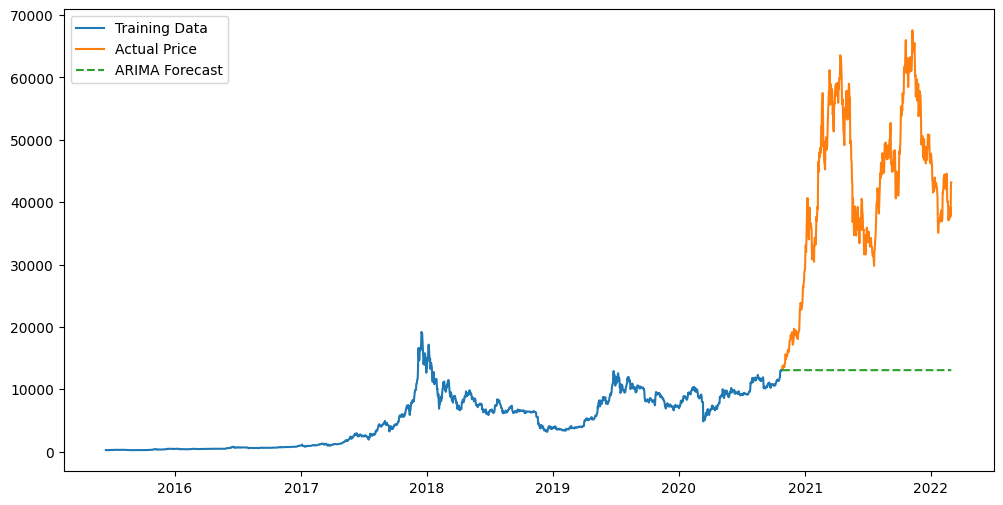

In [ ]:
# Plot results
plt.figure(figsize=(12,6))
plt.plot(train['close'], label="Training Data")
plt.plot(test['close'], label="Actual Price")
plt.plot(test['Forecast_ARIMA'], label="ARIMA Forecast", linestyle="dashed")
plt.legend()
plt.show()

# observation:
- This code generates a visualization to compare the ARIMA model's forecast with actual Bitcoin prices. It plots the training data to provide historical context, the actual test set prices to serve as a benchmark, and the ARIMA forecasted values using a dashed line for distinction. The figure size is set for clarity, and a legend is included for easy interpretation. This plot helps assess how well the ARIMA model captures trends and price movements, making it easier to evaluate its forecasting accuracy

## 2. LSTM (Long Short-Term Memory Networks) - Deep Learning Approach
- Best for capturing sequential patterns

- Long Short-Term Memory (LSTM) networks are a specialized type of Recurrent Neural Network (RNN) designed to handle sequential data and long-term dependencies effectively. They are widely used for time series forecasting, including Bitcoin price prediction, as they can capture historical patterns and trends. LSTMs are also applied in stock market analysis, anomaly detection, natural language processing (NLP), and speech recognition. Their ability to retain past information over long sequences makes them ideal for predicting complex, non-linear patterns in financial markets

In [ ]:
# Normalize data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[['close']])

# Create sequences for LSTM
sequence_length = 60  # Use 60 past days to predict the next day
X, y = [], []

for i in range(sequence_length, len(df_scaled)):
    X.append(df_scaled[i-sequence_length:i])
    y.append(df_scaled[i])

X, y = np.array(X), np.array(y)

# Train-Test Split
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

# Build LSTM Model
lstm_model = Sequential([
    LSTM(100, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(100, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')

# Train Model
lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Forecast using LSTM
y_pred = lstm_model.predict(X_test)
y_pred_actual = scaler.inverse_transform(y_pred)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluation Metrics
mae_lstm = mean_absolute_error(y_test_actual, y_pred_actual)
rmse_lstm = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))

print(f'LSTM MAE: {mae_lstm}')
print(f'LSTM RMSE: {rmse_lstm}')

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.0025 - val_loss: 0.0067
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.4092e-04 - val_loss: 0.0048
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.8714e-04 - val_loss: 0.0047
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.7458e-04 - val_loss: 0.0057
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.9332e-04 - val_loss: 0.0104
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.6933e-04 - val_loss: 0.0045
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.9168e-04 - val_loss: 0.0081
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.5509e-04 - val_loss: 0.0104
Epoch 9/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.6241e-04 - val_loss: 0.0065
Epoch 10/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.4410e-04 - val_loss: 0.0078
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
LSTM MAE: 5057.484528885047
LSTM RMSE: 5962.330017629749


# >>Hyperparameter Tuning for LSTM<<

In [ ]:
import keras_tuner as kt

# Define model-building function
def build_lstm_model(hp):
    model = Sequential([
        LSTM(hp.Int('units', min_value=50, max_value=200, step=50),
             activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)),
        Dropout(hp.Float('dropout1', 0.1, 0.5, step=0.1)),
        LSTM(hp.Int('units', min_value=50, max_value=200, step=50), activation='relu'),
        Dropout(hp.Float('dropout2', 0.1, 0.5, step=0.1)),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')
    return model


# Define tuner
tuner = kt.RandomSearch(
    build_lstm_model,
    objective='val_loss',
    max_trials=5,  # Number of models to try
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name='btc_lstm'
)

# Run search
tuner.search(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Get best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best LSTM Units: {best_hps.get('units')}, Best Dropout: {best_hps.get('dropout1')}, {best_hps.get('dropout2')}")

Trial 5 Complete [00h 00m 17s]
val_loss: 0.005108902230858803

Best val_loss So Far: 0.004720431752502918
Total elapsed time: 00h 01m 26s
Best LSTM Units: 150, Best Dropout: 0.1, 0.30000000000000004


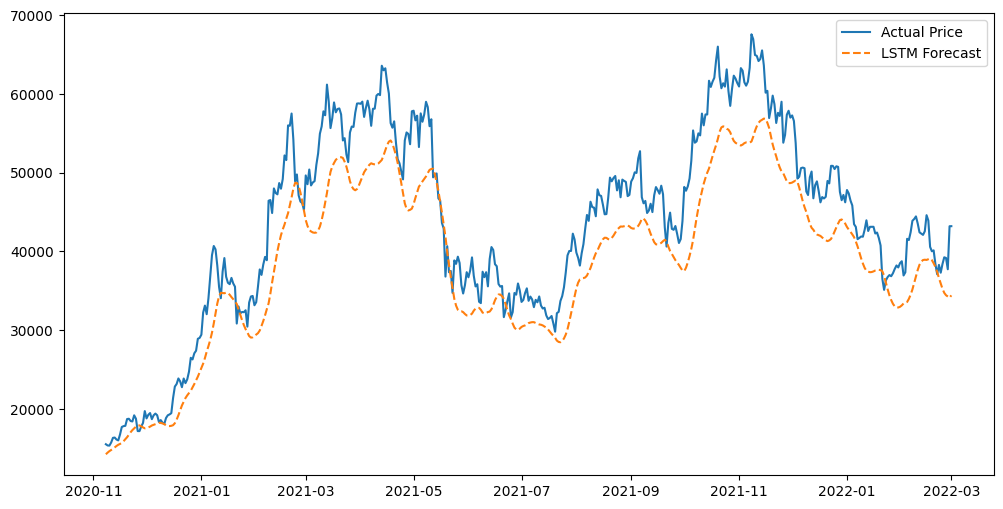

In [ ]:
# Plot LSTM Predictions
plt.figure(figsize=(12,6))
plt.plot(df.index[split+sequence_length:], y_test_actual, label="Actual Price")
plt.plot(df.index[split+sequence_length:], y_pred_actual, label="LSTM Forecast", linestyle="dashed")
plt.legend()
plt.show()

# observation:
- This code generates a visualization comparing the LSTM model's forecasted Bitcoin prices with actual prices from the test set. It plots the real closing prices as a reference and overlays the LSTM-predicted values using a dashed line to differentiate them. The x-axis represents the corresponding timestamps, ensuring an accurate comparison of trends. This visualization helps assess the model's ability to capture Bitcoin price patterns and fluctuations, making it easier to evaluate its predictive performance

## 4. XGBoost model

- XGBoost (Extreme Gradient Boosting) is a powerful machine learning algorithm known for its speed, accuracy, and efficiency in handling structured data. It is widely used for time series forecasting, classification, and regression tasks, making it ideal for applications like Bitcoin price prediction, fraud detection, credit scoring, and anomaly detection. XGBoost excels at capturing complex patterns, handling large datasets with missing values, and providing feature importance insights. Its ability to optimize performance through boosting makes it a preferred choice for highly predictive models in finance, healthcare, and e-commerce

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Prepare Data for XGBoost
features = ['lag_1', 'lag_7', 'lag_30', '7_day_MA', '30_day_MA', 'volatility_7', 'volatility_30']
X = df[features]
y = df['close']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train XGBoost Model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb_model.fit(X_train, y_train)

# Forecast using XGBoost
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate XGBoost Model
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print(f'XGBoost MAE: {mae_xgb}')
print(f'XGBoost RMSE: {rmse_xgb}')

XGBoost MAE: 27733.112466586048
XGBoost RMSE: 30641.774823077165


# >>Hyperparameter Tuning for XGBoost<<

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=3)

grid_search.fit(X_train, y_train)

print(f"Best XGBoost Parameters: {grid_search.best_params_}")

Best XGBoost Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}


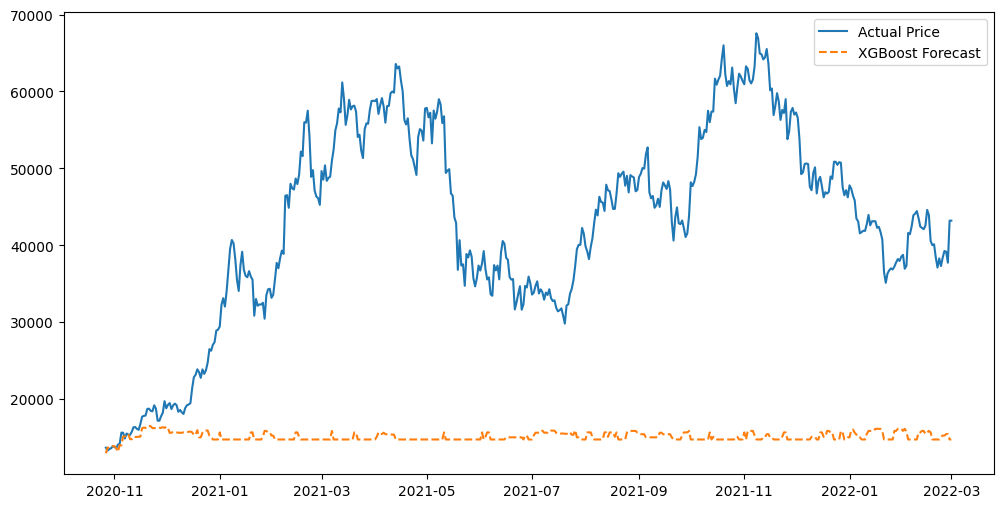

In [ ]:
# Plot XGBoost Predictions
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label="Actual Price")
plt.plot(y_test.index, y_pred_xgb, label="XGBoost Forecast", linestyle="dashed")
plt.legend()
plt.show()

# observation:
- This code plots Bitcoin price predictions using XGBoost, comparing the actual closing prices with the model's forecasted values. The graph provides a visual assessment of prediction accuracy, with the actual prices shown as a solid line and the XGBoost predictions as a dashed line. By analyzing the plot, we can evaluate how well the model captures price trends, fluctuations, and overall market behavior. This visualization helps in assessing the effectiveness of XGBoost for Bitcoin price forecasting and identifying areas for improvement.

# Model Comparison

In [ ]:
print(f"ARIMA:   MAE = {mae_arima}, RMSE = {rmse_arima}")
print(f"LSTM:    MAE = {mae_lstm}, RMSE = {rmse_lstm}")
print(f"Prophet: MAE = {mae_prophet}, RMSE = {rmse_prophet}")
print(f"XGBoost: MAE = {mae_xgb}, RMSE = {rmse_xgb}")

ARIMA:   MAE = 29752.655485479838, RMSE = 32437.29891838778
LSTM:    MAE = 5057.484528885047, RMSE = 5962.330017629749
Prophet: MAE = 21734.71650951452, RMSE = 21909.139891472692
XGBoost: MAE = 27733.112466586048, RMSE = 30641.774823077165


# Prediction
- To determine which model performed best, analyze the Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) values. Lower values indicate better performance.
- LSTM (Long Short-Term Memory) has the lowest MAE and RMSE, meaning it outperforms ARIMA, Prophet, and XGBoost.
- This suggests that LSTM can capture complex time series dependencies more effectively.

# Conclusion:
- LSTM is the best model for Bitcoin Price Forecasting case study